In [816]:
#-*- coding:utf8-*-
%matplotlib inline

from __future__ import absolute_import, division, print_function, unicode_literals

from IPython.display import Image

import numpy as np

import uncertainties as unc
from uncertainties import unumpy as unp
from uncertainties.unumpy import std_devs as stds #TODO
from uncertainties.unumpy import nominal_values as noms #TODO
umean = unc.wrap(np.mean)

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D 

import seaborn as sns

sns.set(context="paper",font_scale=1.6,style="darkgrid")


import scipy as sp
import scipy.constants as const

import sympy as sym
sym.init_printing()

import pandas as pd

import ROOT as rt

import root_numpy as rnp

import re

from aputils.latextables.tables import Table


# Fehlerfortpflanzung beim Mitteln
umean = unc.wrap(np.mean)

#Laden des Latex fonts 
plt.rcParams['text.latex.preamble']=["\\usepackage{lmodern}"]
#Options
params = {'text.usetex' : True,
          'font.size' : 11,
          'font.family' : 'lmodern',
          'text.latex.unicode': True,
          }
plt.rcParams.update(params) 

#Größe der Achsenbeschriftung
axis_font = {'size':'14'}

# Pfade
path_graphics = "../Grafiken/"
path_table = "../Tabellen/"
path_data = "../Messdaten/"

In [73]:
# Funktionen
# Achsenbeschriftungen
def axis_label(label,sym=None,unit=None):
    if sym == None:
        return lable
    elif unit == None:
        return r"".join([label," ${s}$".format(s=sym)])
    else:
        return r"".join([label," ${s}/\mathrm{{{u}}}$".format(s=sym,u=unit)])
    
# Fit Funktionen
def fit_errors(popt,pcov):
    errors = np.sqrt(np.diag(pcov))
    param_err = unp.uarray(popt,errors)
    return param_err
    
def print_errors(array,description=None):
    if description and len(description)==len(array):
        maxlen = max(map(len,description))
        lens = map(len,description)
        for i,entry in enumerate(array):
            print(description[i]," "*(maxlen-lens[i]),entry.nominal_value,"+/-",entry.std_dev)
    else:
        for i,entry in enumerate(array):
            print(entry.nominal_value,"+/-",entry.std_dev)


#Vorbereitungsaufgaben

##Aufgabe 5

In [89]:
#W2 = sym.sqrt(2)
#A_np = np.matrix([[1,1,1,0,0,0,0,0,0],[0,0,0,1,1,1,0,0,0],[0,0,0,0,0,0,1,1,1],
#               [0,0,W2,0,0,0,0,0,0],[0,W2,0,0,0,W2,0,0,0],[W2,0,0,0,W2,0,0,0,W2],
#               [0,0,0,W2,0,0,0,W2,0],[0,0,0,0,0,0,W2,0,0],[0,0,W2,0,0,W2,0,0,W2],
#               [0,W2,0,0,W2,0,0,W2,0],[W2,0,0,W2,0,0,W2,0,0]])
#A = sym.Matrix(A_np)
#B = (A.transpose()*A)
#B.inv()
# B ist singulär

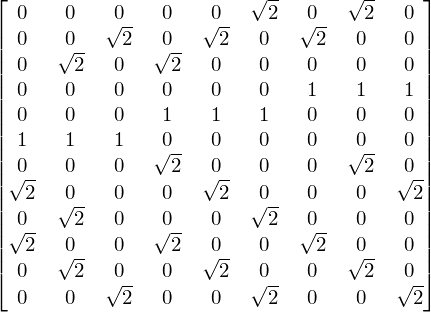

In [976]:
W2 = sym.sqrt(2)
A_np = np.matrix([[0,0,0,0,0,W2,0,W2,0],[0,0,W2,0,W2,0,W2,0,0],[0,W2,0,W2,0,0,0,0,0],
                [0,0,0,0,0,0,1,1,1],[0,0,0,1,1,1,0,0,0],[1,1,1,0,0,0,0,0,0],
               [0,0,0,W2,0,0,0,W2,0],[W2,0,0,0,W2,0,0,0,W2],[0,W2,0,0,0,W2,0,0,0],
               [W2,0,0,W2,0,0,W2,0,0],[0,W2,0,0,W2,0,0,W2,0],[0,0,W2,0,0,W2,0,0,W2]])
#B_np = (A_np.T * A).inv()


A = sym.Matrix(A_np)
C = (A.transpose()*A).inv()
A


##Suche nach Integrationsintervall

In [ ]:
values = [4503,2978,6396,5013,4969,5458,6046,3073,4990,4920,4918,5422]
values = [2994,1296,5373,3239,2978,3603,3220,1323,4363,3224,3099,4188]

filepath = "/home/josh/Dokumente/Studium/FP_Physik/FP_Repo/01_TomographieGamma[ ]/Messdaten/20151102_Joshua_Leonard/Block2/Messung_{}.dat"
global_limits = set([])
for k,n in enumerate(values,start=1):
    global global_limits
    print("Messung {}".format(k))
    File = filepath.format(k)
    x,y = np.loadtxt(File,unpack=True)
    print(y[250:310].sum(),"\t",n)
    limits = set([])
    for i in range(200,300):
        for j in range(250,350):
            if sum(y[i:j]) == n:
                limits.add((i,j))
    if k == 1:
        global_limits = limits
    else:
        global_limits = global_limits.intersection(limits)
                #print(i,j)

print(global_limits)

#Auswertung

##Laden der Daten

In [1049]:
# Speicherort der Messdaten 
folder = path_data+"20151102_Joshua_Leonard/"

# Ordner der Messreihen
cube = ["Luft/","Block1/","Block2/","Block3/"]

# Intergrationsgrenzen
lower_limit, upper_limit = 250, 310

# Kanalnummern
channels = np.arange(0,1024)

#Kanal Maske
in_intervall = np.zeros_like(channels)
in_intervall[lower_limit:upper_limit] = np.ones(60) 
out_intervall = np.logical_not(in_intervall)
in_intervall = np.logical_not(out_intervall)

# Laden der Daten einer Messreihe
def load_data(num_cube=0):
    data = []
    real_times = []
    live_times = []
    for i in range(1,13):
        File = "Messung_{}.dat".format(i) 
        with open(folder+cube[num_cube]+File) as dat:
            line = dat.readline()
            while line:
                if "Real Time" in line: 
                    m = re.search("\d{3}.\d{3}",line)
                    real_times.append(float(m.group(0)))
                if "Live Time" in line:
                    m = re.search("\d{3}.\d{3}",line)
                    live_times.append(float(m.group(0)))
                    break
                line = dat.readline()
        data.append(np.loadtxt(folder+cube[num_cube]+File,unpack=True)[1])
    data,real_times, live_times = np.array(data),np.array(real_times),np.array(live_times)
    return data,real_times,live_times

materials = ["Aluminium","Blei","Delrin","Eisen","Messing"]
densities = np.loadtxt(path_data+"Dichten.txt",unpack=True)

attenuation_coeff_Al_scaled = np.loadtxt(path_data+"Absorbtion_Aluminium.txt",unpack=True)[-1,0]
attenuation_coeff_Al = attenuation_coeff_Al_scaled*densities[0]

attenuation_coeff_Pb_scaled = np.loadtxt(path_data+"Absorbtion_Blei.txt",unpack=True)[-1,0]
attenuation_coeff_Pb = attenuation_coeff_Pb_scaled*densities[1]

attenuation_coeff_Delrin_scaled = np.loadtxt(path_data+"Absorbtion_Delrin.txt",unpack=True)[-1,0]
attenuation_coeff_Delrin = attenuation_coeff_Delrin_scaled*densities[2]

attenuation_coeff_Fe_scaled= np.loadtxt(path_data+"Absorbtion_Eisen.txt",unpack=True)[-1,0]
attenuation_coeff_Fe = attenuation_coeff_Fe_scaled*densities[3]

attenuation_coeff_Brass_scaled = np.loadtxt(path_data+"Absorbtion_Messing.txt",unpack=True)[-1,0]
attenuation_coeff_Brass = attenuation_coeff_Brass_scaled*densities[4]
attenuation_coeffs = np.array([attenuation_coeff_Al,attenuation_coeff_Pb,
                   attenuation_coeff_Delrin,attenuation_coeff_Fe,
                  attenuation_coeff_Brass])
attenuation_coeffs_scaled = [attenuation_coeff_Al_scaled,attenuation_coeff_Pb_scaled,
                   attenuation_coeff_Delrin_scaled,attenuation_coeff_Fe_scaled,
                  attenuation_coeff_Brass_scaled]

In [1017]:
attenuation_coeff_Fe_scaled

In [784]:
for mat,att_coeff in zip(["Aluminium","Blei","Delrin","Eisen","Messing"],[attenuation_coeff_Al,attenuation_coeff_Pb,attenuation_coeff_Delrin,attenuation_coeff_Fe,attenuation_coeff_Brass]):
    print("Absorbtionskoeffizient von ",end="")
    print(mat+":",att_coeff)

Absorbtionskoeffizient von Aluminium: 0.201609
Absorbtionskoeffizient von Blei: 1.24526
Absorbtionskoeffizient von Delrin: 0.115262
Absorbtionskoeffizient von Eisen: 0.580492
Absorbtionskoeffizient von Messing: 0.61914


In [896]:
# Laden der Messdaten und jeweilige Livetime für alle Projektionen und jeden Würfel
cube_0,real_time_0,live_time_0 = load_data(num_cube=0)
cube_1,real_time_1,live_time_1 = load_data(num_cube=1)
cube_2,real_time_2,live_time_2 = load_data(num_cube=2)
cube_3,real_time_3,live_time_3 = load_data(num_cube=3)

# Wurde 12 mal gemessen verlangt ist jedoch nur ein Wert, daher Mittelung
#cube_0 = cube_0.mean(axis=0)
live_time_0_arr = live_time_0
real_time_0 = real_time_0.mean()
live_time_0 = live_time_0.mean()



In [713]:
# Plot eines Spektrums aus der 5.Messung von Cube 1
#plt.xlim(0,1023)
#plt.xlabel("Kanalnummer")
#plt.ylabel("Anzahl der Hits")
#plt.plot(channels,cube_1[4],label=u"Spektrum Würfel 1\n Projektion $I_{5}$ ")
#plt.legend(loc="upper right")
#plt.savefig(path_graphics+"Spektrum_Block_1_Messung_5_0_1023.pdf")

In [715]:
# Plot eines Spektrums aus der 5.Messung von Cube 1
#plt.xlim(0,350)
#plt.xlabel("Kanalnummer")
#plt.ylabel("Anzahl der Hits")
#plt.plot(channels,cube_1[4],label=u"Spektrum Würfel 1\n Projektion $I_{5}$ ")#
#plt.legend(loc="upper left")
#plt.savefig(path_graphics+"Spektrum_Block_1_Messung_5_0_350.pdf")

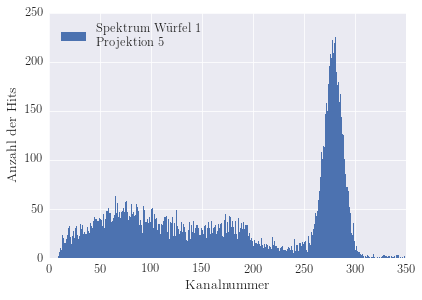

In [1032]:
# Plot eines Spektrums aus der 5.Messung von Cube 1
plt.xlim(0,350)
plt.xlabel("Kanalnummer")
plt.ylabel("Anzahl der Hits")
plt.bar(channels,cube_1[4],width=1,align="center",edgecolor="",label=u"Spektrum Würfel 1\n Projektion 5")
plt.legend(loc="upper left")
plt.savefig(path_graphics+"Spektrum_Block_1_Messung_5_0_350_histogram.pdf")

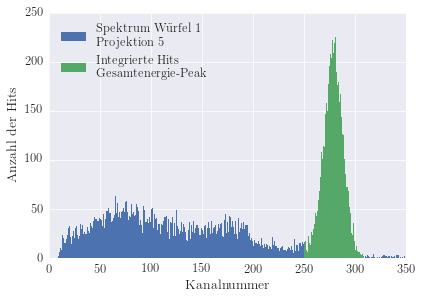

In [1034]:
# Plot eines Spektrums aus der 5.Messung von Cube 1
plt.xlim(0,350)
plt.ylim(0,250)
plt.xlabel("Kanalnummer")
plt.ylabel("Anzahl der Hits")
plt.bar(channels[out_intervall],cube_1[4,out_intervall],width=1,align="center",edgecolor="",label=u"Spektrum Würfel 1\n Projektion 5")
plt.bar(channels[in_intervall],cube_1[4,in_intervall],width=1,align="center",edgecolor="",
        color=sns.palettes.color_palette()[1],label=u"Integrierte Hits\n Gesamtenergie-Peak")
plt.legend(loc="upper left")
plt.savefig(path_graphics+"Spektrum_Block_1_Messung_5_0_350_histogram_intervall.pdf")

In [632]:
cube_1[4,in_intervall].sum()

In [790]:
live_time_0
cube_0

array([[ 0.,  0.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  2.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [890]:
# Integrierte Hits im Intervall [250,310] 
# Cube 0 wurde 12 mal gemessen verlangt ist jedoch nur ein Wert, daher Mittelung
integrated_counts_0_arr = cube_0[:,lower_limit:upper_limit].sum(axis=1)
integrated_counts_1 = cube_1[:,lower_limit:upper_limit].sum(axis=1)
integrated_counts_2 = cube_2[:,lower_limit:upper_limit].sum(axis=1)
integrated_counts_3 = cube_3[:,lower_limit:upper_limit].sum(axis=1)
integrated_counts_0 = integrated_counts_0_arr.mean()


In [844]:
integrated_counts_0

In [893]:
# Fehlerbehaftete Integrierte Hits im Intervall [250,310]
integrated_counts_0_arr_err = unp.uarray(integrated_counts_0_arr,np.sqrt(integrated_counts_0_arr)) 
integrated_counts_0_err = unp.uarray(integrated_counts_0,np.sqrt(integrated_counts_0)) 
integrated_counts_1_err = unp.uarray(integrated_counts_1,np.sqrt(integrated_counts_1)) 
integrated_counts_2_err = unp.uarray(integrated_counts_2,np.sqrt(integrated_counts_2))
integrated_counts_3_err = unp.uarray(integrated_counts_3,np.sqrt(integrated_counts_3)) 


In [847]:
integrated_counts_0_err

array(29374.75+/-171.39063568351685, dtype=object)

In [848]:
# Renormierung der integrierten Hits
integrated_counts_0_norm_1 = integrated_counts_0*(live_time_1/live_time_0)
integrated_counts_1_norm = integrated_counts_1

integrated_counts_0_norm_2 = integrated_counts_0*(live_time_2/live_time_0)
integrated_counts_2_norm = integrated_counts_2

integrated_counts_0_norm_3 = integrated_counts_0*(live_time_3/live_time_0)
integrated_counts_3_norm = integrated_counts_3



In [849]:
integrated_counts_0_norm_3
live_time_0

In [850]:
# Renormierung der fehlerbehafteten integrierten Hits
integrated_counts_0_norm_1_err = integrated_counts_0_err*(live_time_1/live_time_0)
integrated_counts_1_norm_err = integrated_counts_1_err

integrated_counts_0_norm_2_err = integrated_counts_0_err*(live_time_2/live_time_0)
integrated_counts_2_norm_err = integrated_counts_2_err

integrated_counts_0_norm_3_err = integrated_counts_0_err*(live_time_3/live_time_0)
integrated_counts_3_norm_err = integrated_counts_3_err


In [851]:
integrated_counts_1_norm_err

array([4503.0+/-67.10439627923047, 2978.0+/-54.57105459856901,
       6396.0+/-79.97499609252883, 5013.0+/-70.80254232723568,
       4969.0+/-70.49113419430843, 5458.0+/-73.87827826905551,
       6046.0+/-77.75602870517501, 3073.0+/-55.4346462061408,
       4990.0+/-70.63993204979744, 4920.0+/-70.14271166700073,
       4918.0+/-70.12845356914696, 5422.0+/-73.63423117002037], dtype=object)

In [852]:
# Logarithmierte Verhältnisse
log_ratios_1 = np.log(integrated_counts_0_norm_1/integrated_counts_1_norm)
log_ratios_2 = np.log(integrated_counts_0_norm_2/integrated_counts_2_norm)
log_ratios_3 = np.log(integrated_counts_0_norm_3/integrated_counts_3_norm)

In [853]:
# Fehlerbehaftete Logarithmierte Verhältnisse
log_ratios_1_err = unp.log(integrated_counts_0_norm_1_err/integrated_counts_1_norm_err)
log_ratios_2_err = unp.log(integrated_counts_0_norm_2_err/integrated_counts_2_norm_err)
log_ratios_3_err = unp.log(integrated_counts_0_norm_3_err/integrated_counts_3_norm_err)

In [854]:
log_ratios_1_err

array([1.876714141806076+/-0.016003656322588235,
       2.2892038774085117+/-0.01923119026606112,
       1.5252842279696597+/-0.013798208588115313,
       1.7694234448441442+/-0.015281498336607177,
       1.777070072785864+/-0.015339184426845598,
       1.6840416152693878+/-0.014739746898455457,
       1.5817271411982683+/-0.014122374218575384,
       2.258970630951593+/-0.01895937095265598,
       1.77352111317794+/-0.015311552648932062,
       1.787481449924443+/-0.015404378450237363,
       1.7875538678763279+/-0.01540706110248603,
       1.689991060593855+/-0.014780955016094973], dtype=object)

In [855]:
np.diag(sym.Matrix(np.diag(1/(stds(log_ratios_1_err)))**2))

array([3904.46529802009, 2703.88160202765, 5252.36124487186,
       4282.21159424504, 4250.06391992721, 4602.77714220095,
       5014.00276673983, 2781.96814108836, 4265.41739718753,
       4214.16601666436, 4212.69861705463, 4577.14856990955], dtype=object)

In [856]:
type(log_ratios_1[0])

numpy.float64

In [1035]:
# Berechnung der Absorbtionskoeffizienten
def attenuation_coefficients(log_ratios):
    W2 = sym.sqrt(2)
    A_np = np.matrix([[0,0,0,0,0,W2,0,W2,0],[0,0,W2,0,W2,0,W2,0,0],[0,W2,0,W2,0,0,0,0,0],
                [0,0,0,0,0,0,1,1,1],[0,0,0,1,1,1,0,0,0],[1,1,1,0,0,0,0,0,0],
               [0,0,0,W2,0,0,0,W2,0],[W2,0,0,0,W2,0,0,0,W2],[0,W2,0,0,0,W2,0,0,0],
               [W2,0,0,W2,0,0,W2,0,0],[0,W2,0,0,W2,0,0,W2,0],[0,0,W2,0,0,W2,0,0,W2]])
    A = sym.Matrix(A_np)
    
    if not type(log_ratios[0]) == np.float64:
        log_ratios_stds = stds(log_ratios)
        log_ratios = noms(log_ratios)
        attenuation_coeff_std = []
        attenuation_coeff = []
        W = sym.Matrix(np.diag(1/(log_ratios_stds)**2))
        C = (A.transpose()*W*A).inv()
        coeffs = C*A.transpose()*W*log_ratios
        for std in np.diag(C):
            attenuation_coeff_std.append(np.sqrt(float(std)))
        for coeff in coeffs:
            attenuation_coeff.append(float(coeff))
        return unp.uarray(attenuation_coeff,attenuation_coeff_std),C
    else:
        C = (A.transpose()*A).inv()
        coeffs = C*A.transpose()*log_ratios
        
        attenuation_coeff = []
        for coeff in coeffs:
            attenuation_coeff.append(float(coeff))
        return np.array(attenuation_coeff)    




In [1036]:
attenuation_coeff_1_err,C_1 = attenuation_coefficients(log_ratios_1_err)
attenuation_coeff_2_err,C_2 = attenuation_coefficients(log_ratios_2_err)
attenuation_coeff_3_err,C_3 = attenuation_coefficients(log_ratios_3_err)
                                                   

In [1052]:
def relative_error(measurement,theory):
    return abs(theory - measurement)/theory

In [1048]:
for m,a in zip(materials,attenuation_coeffs):
    print(m+":",a)

Aluminium: 0.201609
Blei: 1.24526
Delrin: 0.115262
Eisen: 0.580492
Messing: 0.61914


In [1050]:
attenuation_coeff_1_mean_err =  umean(attenuation_coeff_1_err)
attenuation_coeff_1_mean_err

0.5057958988942443+/-0.0027091098694766746

In [1053]:
relative_error(noms(attenuation_coeff_1_mean_err),attenuation_coeffs)

array([ 1.50879623,  0.59382306,  3.38822768,  0.12867723,  0.183067  ])

In [1044]:
attenuation_coeff_2_mean_err = umean(attenuation_coeff_2_err)
attenuation_coeff_2_mean_err 

0.9022397238366224+/-0.0033773063260108846

In [1055]:
relative_error(noms(attenuation_coeff_2_mean_err),attenuation_coeffs)

array([ 3.47519567,  0.27546077,  6.82772921,  0.55426728,  0.4572467 ])

In [1045]:
attenuation_coeff_3_err

array([0.7791410739782232+/-0.009821859615587824,
       0.6788053303459075+/-0.006726195135584518,
       0.41501855770818136+/-0.00988949219862878,
       0.35204533524707554+/-0.00639852992017997,
       0.6476558815591269+/-0.008091161834010742,
       1.029690097919151+/-0.007745424752001476,
       0.7998247656269883+/-0.00991011153616368,
       0.680840527249522+/-0.006745555219016392,
       0.46721996390834075+/-0.01003221315018068], dtype=object)

In [1057]:
for coeff in attenuation_coeff_3_err:
    print(relative_error(noms(coeff),attenuation_coeffs))

[ 2.86461455  0.37431454  5.75973932  0.34220812  0.25842471]
[ 2.36693962  0.45488867  4.88923783  0.16936208  0.09636808]
[ 1.0585319   0.66672136  2.60065379  0.28505723  0.32968544]
[ 0.74617867  0.7172917   2.05430528  0.39353973  0.43139623]
[ 2.21243537  0.47990309  4.61898875  0.11570165  0.04605724]
[ 4.10736176  0.17311236  7.93347415  0.77382306  0.66309736]
[ 2.96720764  0.3577046   5.93918868  0.37783943  0.29183184]
[ 2.37703439  0.45325432  4.90689496  0.17286806  0.09965521]
[ 1.31745589  0.62480128  3.05354726  0.19513109  0.24537267]


###Tabellen der Messwerte und Ergebnisse

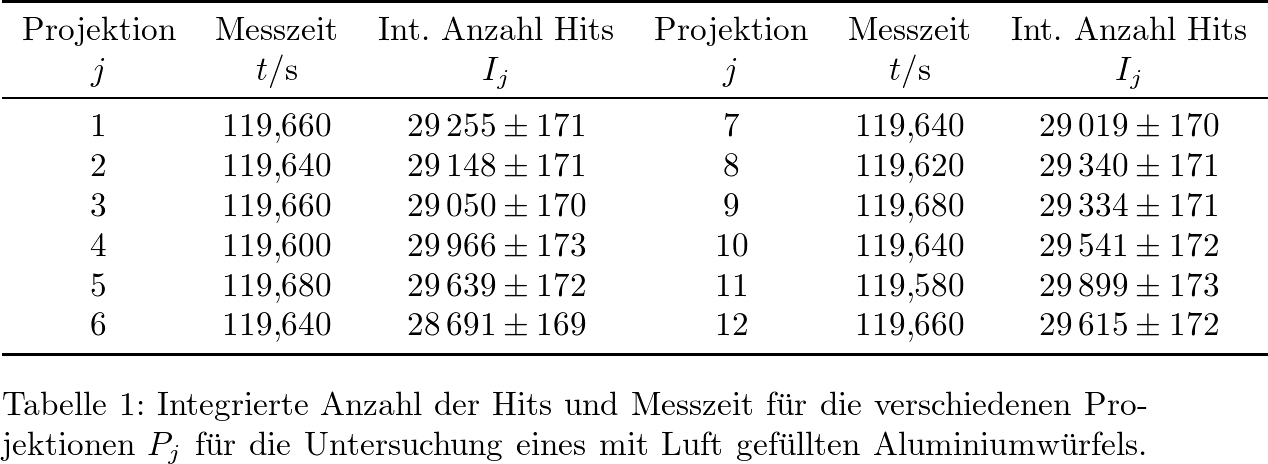

In [997]:
tab_cube_0 = Table(booktabs=True,siunitx=True)
tab_cube_0.caption("""Integrierte Anzahl der Hits und Messzeit  für die 
                      verschiedenen Projektionen $P_{j}$ für die Untersuchung eines mit Luft 
                      gefüllten Aluminiumwürfels.""")
tab_cube_0.label("Messung_I0")
tab_cube_0.addColumn(range(1,13)[:6],title="Projektion",symbol="j")
tab_cube_0.addColumn(live_time_0_arr[:6], title="Messzeit",symbol="t",unit="\second")
tab_cube_0.addColumn(integrated_counts_0_arr_err[:6], title="Int. Anzahl Hits",symbol="I_j")
tab_cube_0.addColumn(range(1,13)[6:],title="Projektion",symbol="j")
tab_cube_0.addColumn(live_time_0_arr[6:], title="Messzeit",symbol="t",unit="\second")
tab_cube_0.addColumn(integrated_counts_0_arr_err[6:], title="Int. Anzahl Hits",symbol="I_j")
Image(tab_cube_0.show(ipynb=True,quiet=False),width=600)
#tab_cube_0.save(path_table+"Messung_I0.tex")

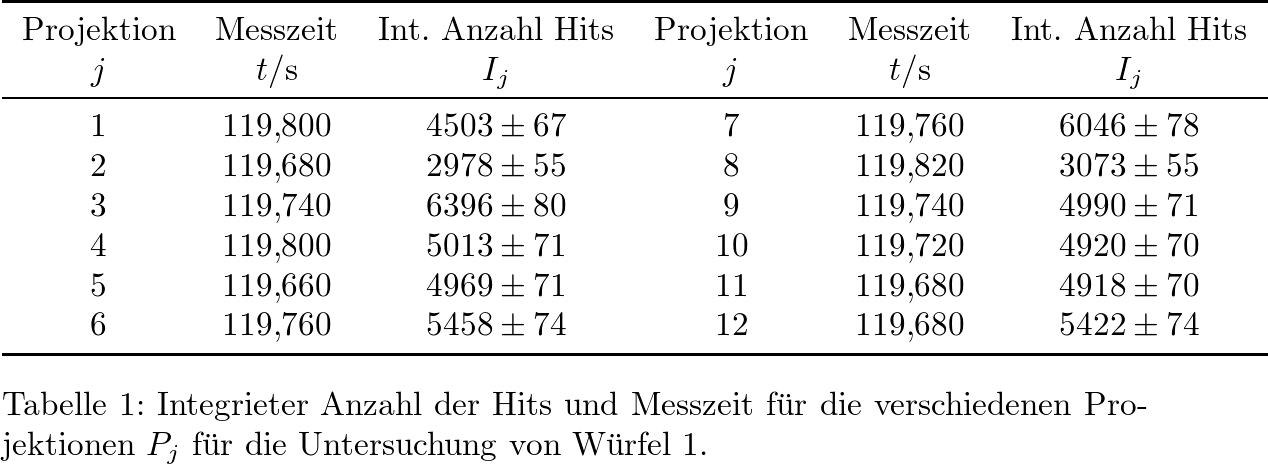

In [995]:
tab_cube_1 = Table(booktabs=True,siunitx=True)
tab_cube_1.caption("""Integrieter Anzahl der Hits und Messzeit für die verschiedenen Projektionen $P_{j}$ für die
Untersuchung von Würfel 1. """)
tab_cube_1.label("Messung_I1")
tab_cube_1.addColumn(range(1,13)[:6],title="Projektion",symbol="j")
tab_cube_1.addColumn(live_time_1[:6], title="Messzeit",symbol="t",unit="\second")
tab_cube_1.addColumn(integrated_counts_1_err[:6], title="Int. Anzahl Hits",symbol="I_j")
tab_cube_1.addColumn(range(1,13)[6:],title="Projektion",symbol="j")
tab_cube_1.addColumn(live_time_1[6:], title="Messzeit",symbol="t",unit="\second")
tab_cube_1.addColumn(integrated_counts_1_err[6:], title="Int. Anzahl Hits",symbol="I_j")
Image(tab_cube_1.show(ipynb=True,quiet=False),width=600)
#tab_cube_1.save(path_table+"Messung_I1.tex")

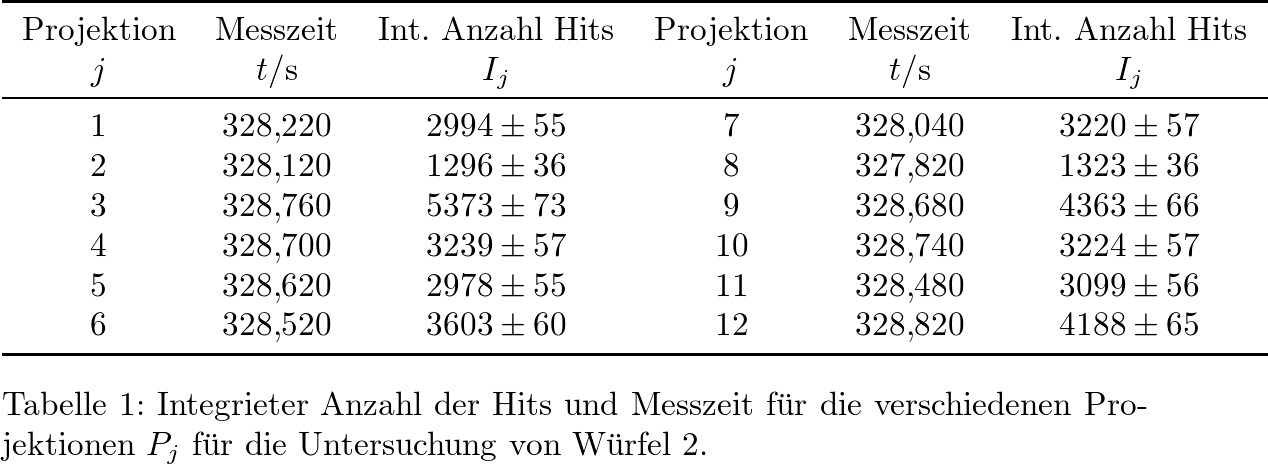

In [993]:
tab_cube_2 = Table(booktabs=True,siunitx=True)
tab_cube_2.caption("""Integrieter Anzahl der Hits und Messzeit für die verschiedenen Projektionen $P_{j}$ für die 
Untersuchung von Würfel 2. """)
tab_cube_2.label("Messung_I2")
tab_cube_2.addColumn(range(1,13)[:6],title="Projektion",symbol="j")
tab_cube_2.addColumn(live_time_2[:6], title="Messzeit",symbol="t",unit="\second")
tab_cube_2.addColumn(integrated_counts_2_err[:6], title="Int. Anzahl Hits",symbol="I_j")
tab_cube_2.addColumn(range(1,13)[6:],title="Projektion",symbol="j")
tab_cube_2.addColumn(live_time_2[6:], title="Messzeit",symbol="t",unit="\second")
tab_cube_2.addColumn(integrated_counts_2_err[6:], title="Int. Anzahl Hits",symbol="I_j")
Image(tab_cube_2.show(ipynb=True,quiet=False),width=600)
#tab_cube_2.save(path_table+"Messung_I2.tex")

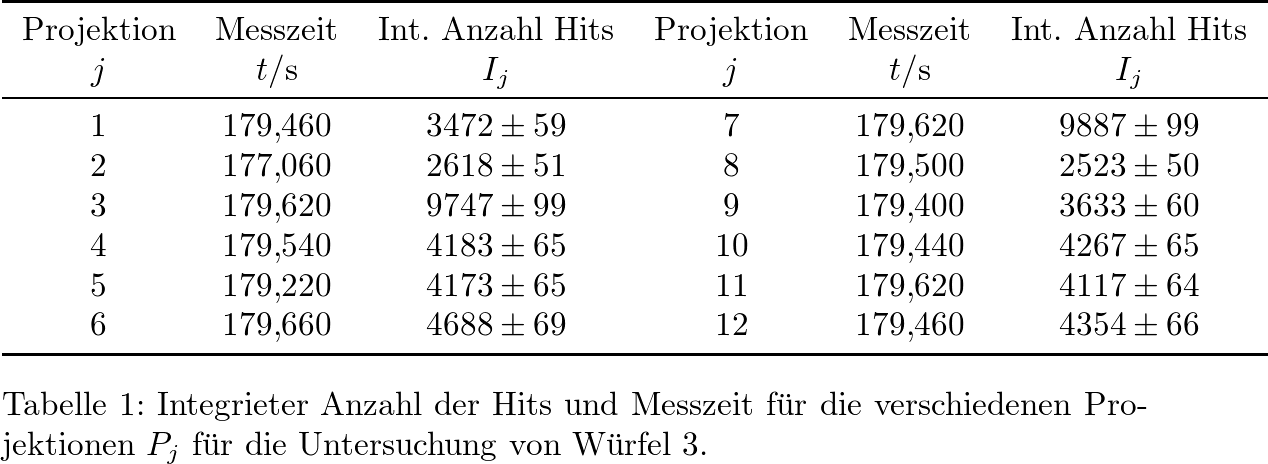

In [991]:
tab_cube_3 = Table(booktabs=True,siunitx=True)
tab_cube_3.caption("""Integrieter Anzahl der Hits und Messzeit für die verschiedenen Projektionen $P_{j}$ für die
Untersuchung von Würfel 3. """)
tab_cube_3.label("Messung_I3")
tab_cube_3.addColumn(range(1,13)[:6],title="Projektion",symbol="j")
tab_cube_3.addColumn(live_time_3[:6], title="Messzeit",symbol="t",unit="\second")
tab_cube_3.addColumn(integrated_counts_3_err[:6], title="Int. Anzahl Hits",symbol="I_j")
tab_cube_3.addColumn(range(1,13)[6:],title="Projektion",symbol="j")
tab_cube_3.addColumn(live_time_3[6:], title="Messzeit",symbol="t",unit="\second")
tab_cube_3.addColumn(integrated_counts_3_err[6:], title="Int. Anzahl Hits",symbol="I_j")
Image(tab_cube_3.show(ipynb=True,quiet=False),width=600)
#tab_cube_3.save(path_table+"Messung_I3.tex")

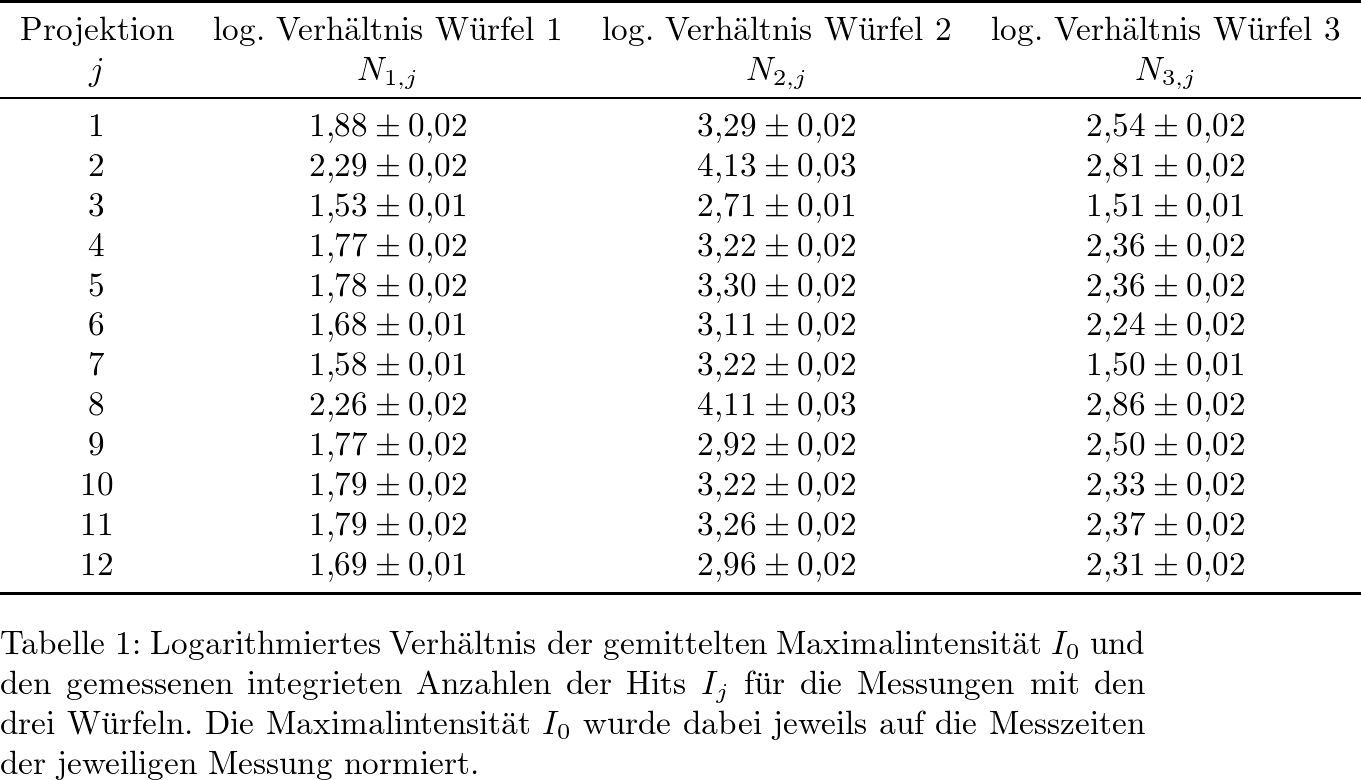

In [1002]:
tab_cube_0_norm = Table(booktabs=True,siunitx=True)
tab_cube_0_norm.caption("""Logarithmiertes Verhältnis der gemittelten Maximalintensität $I_0$ und den gemessenen  
integrierten Anzahlen der Hits $I_j$ für die Messungen mit den drei Würfeln. Die Maximalintensität $I_0$ wurde dabei 
jeweils auf die Messzeiten der jeweiligen Messung normiert.""")
tab_cube_0_norm.label("Messung_Verhaeltnis")
tab_cube_0_norm.addColumn(range(1,13),title="Projektion",symbol="j")
tab_cube_0_norm.addColumn(log_ratios_1_err, title="log. Verhältnis Würfel 1",symbol="N_{1,j}")
tab_cube_0_norm.addColumn(log_ratios_2_err, title="log. Verhältnis Würfel 2",symbol="N_{2,j}")
tab_cube_0_norm.addColumn(log_ratios_3_err, title="log. Verhältnis Würfel 3",symbol="N_{3,j}")
Image(tab_cube_0_norm.show(ipynb=True,quiet=False),width=600)
#tab_cube_0_norm.save(path_table+"Messung_Verhaeltnis.tex")

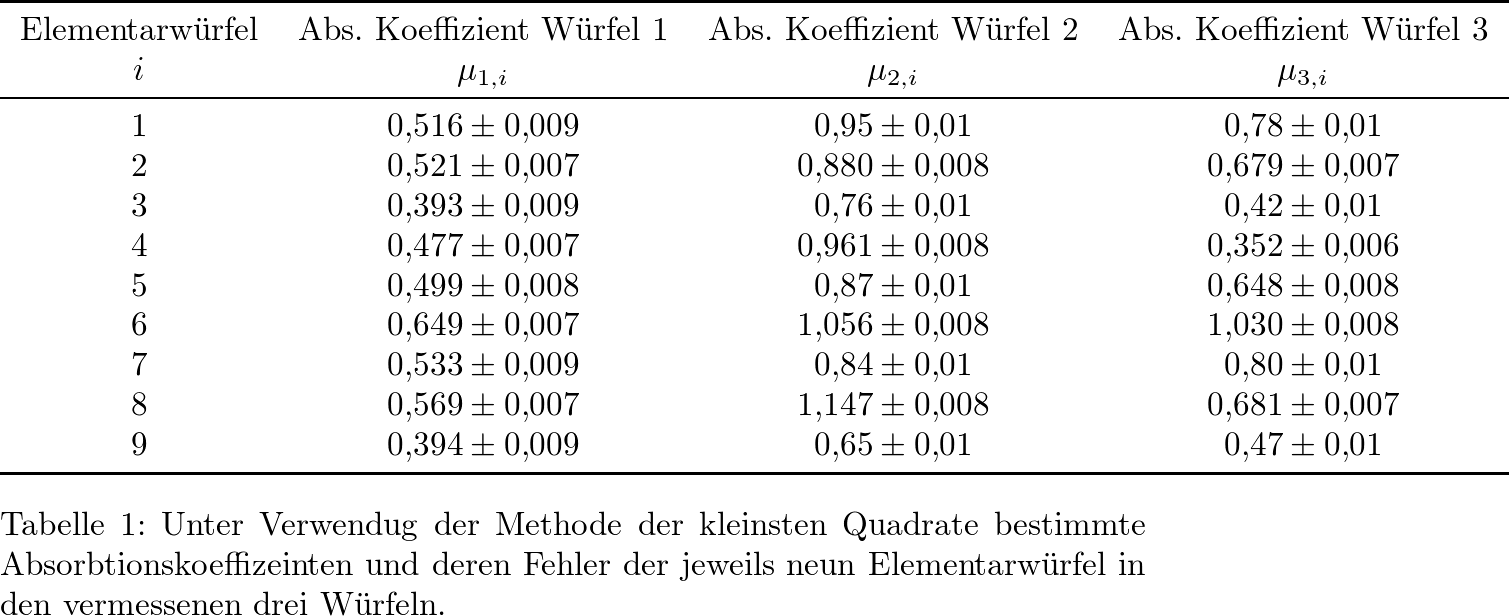

In [1000]:
tab_cube_coeffs = Table(booktabs=True,siunitx=True)
tab_cube_coeffs.caption("""Unter Verwendug der Methode der kleinsten Quadrate bestimmte Absorbtionskoeffizeinten 
und deren Fehler der jeweils neun Elementarwürfel in den vermessenen drei Würfeln.""")
tab_cube_coeffs.label("Absorbtionskoeffizienten")
tab_cube_coeffs.addColumn(range(1,10),title="Elementarwürfel",symbol="i")
tab_cube_coeffs.addColumn(attenuation_coeff_1_err, title="Abs. Koeffizient Würfel 1",symbol="\mu_{1,i}")
tab_cube_coeffs.addColumn(attenuation_coeff_2_err, title="Abs. Koeffizient Würfel 2",symbol="\mu_{2,i}")
tab_cube_coeffs.addColumn(attenuation_coeff_3_err, title="Abs. Koeffizient Würfel 3",symbol="\mu_{3,i}")
Image(tab_cube_coeffs.show(ipynb=True,quiet=False),width=600)
#tab_cube_coeffs.save(path_table+"Absorbtionskoeffizienten.tex")

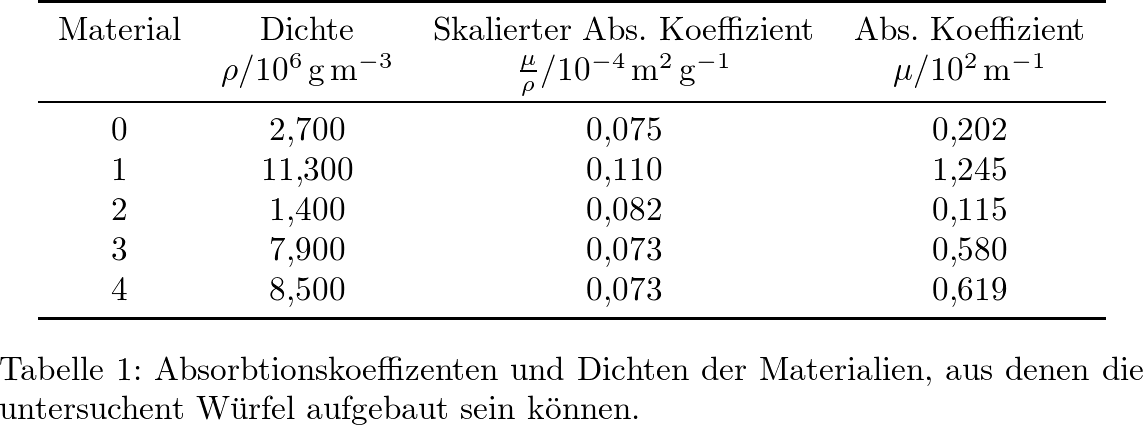

In [1031]:
tab_mat= Table(booktabs=True,siunitx=True)
tab_mat.caption("""Absorbtionskoeffizenten und Dichten der Materialien, aus denen die untersuchent Würfel
aufgebaut sein können.""")
tab_mat.label("Materialien")
tab_mat.addColumn(range(5),title="Material",symbol="")
tab_mat.addColumn(densities, title="Dichte",symbol=r"\rho",unit=r"\gram\per\centi\metre\cubed")
tab_mat.addColumn([attenuation_coeff_Al_scaled,attenuation_coeff_Pb_scaled,
                   attenuation_coeff_Delrin_scaled,attenuation_coeff_Fe_scaled,
                  attenuation_coeff_Brass_scaled], title="Skalierter Abs. Koeffizient",symbol=r"\frac{\mu}{\rho}",
                 unit=r"\centi\metre\squared\per\gram")
tab_mat.addColumn([attenuation_coeff_Al,attenuation_coeff_Pb,
                   attenuation_coeff_Delrin,attenuation_coeff_Fe,
                  attenuation_coeff_Brass], title="Abs. Koeffizient",symbol="\mu",unit=r"\per\centi\metre")
Image(tab_mat.show(ipynb=True,quiet=False),width=600)
#tab_mat.save(path_table+"Materialien.tex")